In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
from operator import attrgetter
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_1 = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'  
public_key_2 = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'  
public_key_3 = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'  

# Получаем загрузочные ссылки
final_url_1 = base_url + urlencode(dict(public_key=public_key_1))
response_1 = requests.get(final_url_1)
download_url_1 = response_1.json()['href']

final_url_2 = base_url + urlencode(dict(public_key=public_key_2))
response_2 = requests.get(final_url_2)
download_url_2 = response_2.json()['href']

final_url_3 = base_url + urlencode(dict(public_key=public_key_3))
response_3 = requests.get(final_url_3)
download_url_3 = response_3.json()['href']

In [3]:
df_customers = pd.read_csv(download_url_1, error_bad_lines=False, comment='#' , encoding='cp1251')
df_orders = pd.read_csv(download_url_2, error_bad_lines=False, comment='#' , encoding='cp1251')
df_order_items = pd.read_csv(download_url_3, error_bad_lines=False, comment='#' , encoding='cp1251')

В этом проекте покупками я буду считать те заказы, что были оплачены и имеют статус "delivered", так как покупка - это приобретение товара в пользование, а поэтому здесь два основных критерия:
- факт оплаты
- факт получения заказа

Такой подход был выбран из-за того, что:

1) заказы без оплаты нельзя считать покупкой;

2) заказы со статусами "canceled" и "unavailable" хоть и были оплачены (не все), но так и не будут получены, а денежные средства клиентам придется вернуть;

3) заказы со статусами "approved", "invoiced", "processing", "shipped" можно было бы учесть как покупки, но очень смущает то, что у заказов до сих пор не поменялся статус на "delivered", "unavailable" или "canceled",  так как если оценивать df с точки зрения 2023 года, то заказ со статусом "invoiced" от 2016 года вызывает много вопросов, учитывая, что все id заказов в таблице olist_orders_dataset.csv уникальны. 
    Если рассматривать df относительно 17.10.2018 (самой свежей даты), то также присутствуют оплаченные заказы, которые не были доставлены за ~1.5 года. 
    Может быть для Бразилии это нормальная история, но в России это выглядит максимально странно.

Поэтому перед подготовкой аналитики я бы обратился к продакт-менеджеру, чтобы он подсказал, нужно ли включать в отчет для него такие заказы.

Если просто отфильтровать исходный df по статусу заказа "delivered", то в полученных данных будут 14 заказов без подтвержденной оплаты, а также 8 заказов без указанной даты доставки. 

Из-за этого я не буду включать эти заказы, т.к. первые не были оплачены, а вторые не были доставлены (при условии, что в df ошибка только в проставленном статусе) 

В df остается еще один заказ без времени передачи в логистическую службу, но этот заказ не противоречит исходным параметрам "покупки", а также возможно был забран самостоятельно, так как в заказе есть дата получения.

Исходя из всего этого df с покупками будет выглядеть следующим образом:



In [4]:
purchase = df_orders.query('order_status == "delivered"') \
.dropna(subset=['order_approved_at','order_delivered_customer_date'])

In [5]:
# Сразу переведем столбец с датой заказа к нужному формату
purchase['order_purchase_timestamp'] = pd.to_datetime(purchase['order_purchase_timestamp'])

# 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [6]:
# Сгруппируем все кастомеры в таблице "purchase", чтобы увидеть повторяются ли они

purchase.groupby('customer_id').agg({'order_id': 'count'}).sort_values(by='order_id', ascending = False).head()

,order_id
customer_id,
00012a2ce6f8dcda20d059ce98491703,1
aa5e0a0c36015d39de864189a2b00b09,1
aa6190994371836fc1d4596edd827abd,1
aa606152f23a5fa9ba3d0b87f7a492e8,1
aa601b3c45980c0918042d5ca7a25054,1


In [7]:
# Так как кастомеры не повторяются, то запишем их все в список
customer_list = list(purchase['customer_id'])

In [8]:
# Так как в таблице "df_customers" у каждого customer_unique_id может быть несколько customer_id, 
# то я создам в этой таблице новый столбец, чтобы найти пересечения со списком кастомеров из таблицы с заказами 
df_customers['filter'] = df_customers['customer_id'].isin(customer_list) 

In [9]:
# Теперь сгруппируем по уникальным id, найдем число пересечений кастомеров из двух таблиц и выберем только единождые пересечения.
# Просуммировав, получаем число уникальных пользователей, которые сделали покупку только один раз!
answer_1 = df_customers.groupby('customer_unique_id').agg({'filter' : 'sum'}).query('filter == 1').sum()

In [10]:
answer_1

filter    90537
dtype: int64

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Так как в таблице с заказами нет четких причин, по которым товар еще не доставлен, то будем исходить из статуса заказа

In [11]:
# Сперва переведем столбцы с датами к нужному формату
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
df_orders['order_approved_at'] = pd.to_datetime(df_orders['order_approved_at'])
df_orders['order_delivered_carrier_date'] = pd.to_datetime(df_orders['order_delivered_carrier_date'])
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'])
df_orders['order_estimated_delivery_date'] = pd.to_datetime(df_orders['order_estimated_delivery_date'])

In [12]:
# Теперь оставим только недоставленные заказы
not_delivered = df_orders[df_orders['order_delivered_customer_date'].isnull()]

In [13]:
# Теперь добавим столбец с годом и месяцем создания заказа
not_delivered["year_month"] = not_delivered["order_purchase_timestamp"].dt.to_period("M")

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# Сгруппируем данные по дате и статусу, чтобы увидеть число недоставленных заказов в каждый из месяцев и их статус
not_delivered_gr = not_delivered.groupby(['year_month', 'order_status'], as_index = False) \
.agg({'order_id':'count'})

In [15]:
# Теперь снова сгруппируем данные из предыдущего шага по статусу заказа, чтобы получить среднее число недоставленных
# заказов, округлив его до целого для лучшего восприятия. 
not_deliv_gr = not_delivered_gr \
.groupby('order_status', as_index = False) \
.agg({'order_id':'mean'}) \
.round() \
.sort_values('order_status')


In [16]:
# Создадим таблицу со статусами заказов и соответствующими причинами, почему заказ еще не у клиента.
# Причина по которой товар не доставлен - это то действие, которое не провели с заказом, чтобы он попал на следующий этап
causes = pd.DataFrame({ 'order_status': ['created', 'approved', 'invoiced', 'processing', 'shipped', 'delivered', 'unavailable', 'canceled'], 'сause': ['не подтвержден', 'не оплачен', 'не отправлен на сборку', 'не отгружен', 'не доставлен', 'не доставлен. ошибка статуса', 'недоступен', 'отменен']})

In [17]:
# Соединим две таблицы, чтобы увидеть детализацию по причинам, по которым заказ не доставлен
answer_2 = not_deliv_gr.merge(causes, how='inner', on='order_status').rename(columns={'order_id': 'count'}).sort_values(by='count', ascending = False)

In [18]:
answer_2

,order_status,count,сause
6,shipped,48.0,не доставлен
7,unavailable,29.0,недоступен
1,canceled,26.0,отменен
5,processing,16.0,не отгружен
4,invoiced,15.0,не отправлен на сборку
2,created,2.0,не подтвержден
3,delivered,2.0,не доставлен. ошибка статуса
0,approved,1.0,не оплачен


# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [19]:
# Сперва создадим новый df на основе исходного df_orders, оставив только id и дату заказа
order_purchase = purchase[['order_id', 'order_purchase_timestamp']]

In [20]:
# На основе даты создадим новую колонку с днем недели по каждой дате
order_purchase['day_name'] = order_purchase.order_purchase_timestamp.dt.day_name()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
# Избавимся от колонки с датой
order_purchase = order_purchase[['order_id', 'day_name']]

In [22]:
# Сгруппируем id продуктов и заказов, чтобы увидеть в скольких заказах встречется каждый товар
product_id_group = df_order_items.groupby(['product_id','order_id'], as_index=False).agg({'seller_id' : 'count'})

In [23]:
# Объединим таблицы, чтобы найти все пересечения
df_merge = product_id_group.merge(order_purchase, how='inner', on='order_id')

In [24]:
# Чтобы увидеть в какие дни и в каком количестве покупается товар, сделаем Пивот-таблицу
df_pivot = df_merge.pivot_table(index='product_id', columns='day_name', values='seller_id', aggfunc='sum') 

In [25]:
# С помощью функции .idxmax(), мы сможем увидеть колонку из сводной таблицы с максимальным значением 
# для каждого индекса, что и будет являться ответом на поставленнную задачу.
answer_3 = df_pivot.idxmax(axis=1).to_frame().rename(columns={0: 'day_name'}).reset_index()

In [26]:
answer_3

,product_id,day_name
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32206,fff6177642830a9a94a0f2cba5e476d1,Saturday
32207,fff81cc3158d2725c0655ab9ba0f712c,Monday
32208,fff9553ac224cec9d15d49f5a263411f,Friday
32209,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


<i> P.S. на самом деле ответ является не совсем корректным, так как функция .idxmax() при нахождении двух одинаковых значений показывает только первое. Как это обойти я так и не придумал, но возможно это не принципиально, когда выбор стоит между двумя значениями равными единице. </i>

In [27]:
# Ну и колличество покупок товаров по дням, для того чтобы увидеть самый популярный день для покупок
answer_3.groupby('day_name', as_index=False).agg({'product_id': 'count'}).sort_values('product_id', ascending = False)

,day_name,product_id
1,Monday,6137
0,Friday,5927
5,Tuesday,4401
4,Thursday,4361
6,Wednesday,4042
3,Sunday,3713
2,Saturday,3630


# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
Не стоит забывать, что внутри месяца может быть не целое количество недель. 
Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Создадим новые дф под задачу:

In [28]:
# Из покупок возьмем данные о id  покупателя и времени заказа
purchase_4 = purchase[['customer_id', 'order_purchase_timestamp']]

In [29]:
# Из таблицы с кастомерами возьмем данные об уникальных id и соответствующим им генерируемым id, чтобы впоследствии
# получить информацию о покупках уникальных пользователей
customers_4 = df_customers[['customer_unique_id','customer_id']]

In [30]:
# Соединим две таблицы
merge_cust = customers_4.merge(purchase_4, how='inner', on='customer_id')

In [31]:
# Приведем колонку с датой заказа к формату 'гггг-мм'
merge_cust["order_purchase_timestamp"] = merge_cust["order_purchase_timestamp"].dt.to_period("M")

In [32]:
# Посчитаем для каждого уникального id кол-во заказов в месяц, по имеющимся данным
merge_cust_4 = merge_cust.groupby(['customer_unique_id','order_purchase_timestamp'], as_index=False).agg({'customer_id':'count'}).sort_values('order_purchase_timestamp')

In [33]:
# Создадим новый столбец, где для каждого месяца будет подсчитано число заказов в неделю
merge_cust_4['week'] = (merge_cust_4.customer_id / (merge_cust_4.order_purchase_timestamp.dt.daysinmonth / 7)).round(2)

In [34]:
# Теперь возьмем для каждого id среднее значение от столбца с числом заказов в неделю, что и будет ответом на задачу
answer_4 = merge_cust_4.groupby('customer_unique_id').agg({'week':'mean'}).sort_values(by='week', ascending = False)

In [35]:
answer_4

,week
customer_unique_id,
12f5d6e1cbf93dafd9dcc19095df0b3d,1.35
a239b8e2fbce33780f1f1912e2ee5275,1.00
b08fab27d47a1eb6deda07bfd965ad43,0.93
25a560b9a6006157838aab1bdbd68624,0.93
c8460e4251689ba205045f3ea17884a1,0.90
...,...
59333c2cc7727eeef6170c26b71565f7,0.23
59323be0d75fda67f1b8493f2c56c01e,0.23
59320290aeb1ca17c488a7090a1c0944,0.23


# 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [36]:
# Определим каждого пользователя в когорту исходя из месяца и года первой покупки
cohort = merge_cust.groupby('customer_unique_id', as_index=False).agg({'order_purchase_timestamp': 'min'}).sort_values('order_purchase_timestamp').rename(columns={'order_purchase_timestamp': 'cohort'})

In [37]:
# Добавим когорты в дф с id пользователей и заказами
merge_cust_cohort = merge_cust.merge(cohort, how='inner', on='customer_unique_id')

In [38]:
# Узнаем разброс по датам в нашем дф
print('Заказы с {} по {}'.format(merge_cust_cohort['order_purchase_timestamp'].min(),
                                    merge_cust_cohort['order_purchase_timestamp'].max()))

Заказы с 2016-09 по 2018-08


Так как в дф заказы с 2016-09 по 2018-08, а по заданию нужно рассмотреть период с января по декабрь, то для анализа возьмем 2017 полный год.

In [39]:
# посмотрим для каждой когорты количество пользователей в последующие месяцы
cohort_retention = merge_cust_cohort.groupby(['cohort','order_purchase_timestamp'], as_index=False).agg({'customer_unique_id':'count'}).rename(columns={'customer_unique_id': 'count_users'}).query("'2017-01' <= cohort <= '2017-12'")

In [40]:
# сделаем новую колонку с номером месяца в когорте
cohort_retention['period'] = (cohort_retention.order_purchase_timestamp - cohort_retention.cohort).apply(attrgetter('n'))

In [41]:
# отберем из дф данные по трем месяцам в каждой когорте.
# третий месяц - это "месяц первой покупки + 2", т.е. 2 период
cohort_retention = cohort_retention.query("0 <= period <= 2")

In [42]:
# Сделаем прошлый дф более наглядным и выведем когорту, первые три месяца по ней, и число пользователей в каждый месяц
cohort_count = cohort_retention.pivot(index='cohort', columns = 'period', values = 'count_users')

In [43]:
# Посчитаем retention на третий месяц по каждой когорте
cohort_count['retention (%)'] = ((cohort_count[2]/cohort_count[0])*100).round(2)

In [44]:
# Выведем когорту с самым высоким retention на 3й месяц
answer_5 = cohort_count[cohort_count['retention (%)'] == cohort_count['retention (%)']. max ()]
answer_5

period,0,1,2,retention (%)
cohort,,,,
2017-09,4070,28,22,0.54


# 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. 
Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, 
F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. 
Подробно опиши, как ты создавал кластеры. 
Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 
Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2)имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

Подготовим датафреймы:

In [45]:
# Сделаем дф с id заказа и суммой всех товарных позиций в нем
orders = df_order_items.groupby('order_id', as_index=False).agg({'price':'sum'})

In [46]:
# Возьмем все пользовательские id с совершенными покупками
cust_purchase = customers_4.merge(purchase, how='inner', on='customer_id')

In [47]:
# объединим дф
df_6 = cust_purchase.merge(orders, how='inner', on='order_id')[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'price']].rename(columns={'order_purchase_timestamp': 'invoice_date'})

In [48]:
# ДФ для решения задачи
df_6

,customer_unique_id,order_id,invoice_date,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,230.00
...,...,...,...,...
96451,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07 15:48:17,74.90
96452,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04 08:20:22,114.90
96453,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08 20:11:50,37.00
96454,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:08:33,689.00


In [49]:
# Узнаем разброс по датам в нашем дф
print('Заказы с {} по {}'.format(df_6['invoice_date'].min(),
                                    df_6['invoice_date'].max()))

Заказы с 2016-09-15 12:16:38 по 2018-08-29 15:00:37


Так как в дф заказы с 2016-09-15 по 2018-08-29, а для RFM-сегментации (судя по материалу по ссылке) лучше подходят данные за 1 год, то возьмем данные за 2017 полный год.

In [50]:
df_6 = df_6.query("'2017-01-01' <= invoice_date <= '2017-12-31'")
period = 365

In [51]:
# Текущей датой обозначим максимальную дату из полученного дф + 1 день
NOW = df_6['invoice_date'].max() + timedelta(days=1)

In [52]:
# Подсчитаем прошедшее число дней с заказа
df_6['DaysSinceOrder'] = df_6['invoice_date'].apply(lambda x: (NOW - x).days)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Для того чтобы вывести метрики для RFM-анализа, создадим словарь, где каждому нужному для рассчетов параметру, будет соответствовать функция, с помощью которой и будут произведены нужные расчеты.

In [53]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # найдем число дней прошедших с последнего заказа
    'invoice_date': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # общее число заказов за рассматриваемый период
    'price': lambda x: x.sum() # сумма чеков по заказам
}
rfm = df_6.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'invoice_date': 'Frequency', 'customer_unique_id' : 'CustomerID', 'price':'Monetary'}, inplace=True)
rfm

,CustomerID,Recency,Frequency,Monetary
0,0000f46a3911fa3c0805444483337064,296,1,69.00
1,0000f6ccb0745a6a4b88665a16c9f078,80,1,25.99
2,0004aac84e0df4da2b147fca70cf8255,47,1,180.00
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00
4,0006fdc98a402fceb4eb0ee528f6a8d4,166,1,13.90
...,...,...,...,...
42046,fffbf87b7a1a6fa8b03f081c5f51a201,4,1,149.00
42047,fffcf5a5ff07b0908bd4e2dbc735a684,206,1,1570.00
42048,fffea47cd6d3cc0a88bd621562a9d061,21,1,64.89
42049,ffff371b4d645b6ecea244b27531430a,327,1,89.90


Суть RFM-анализа — в сегментации клиентов в зависимости от давности покупки, частоты и суммы потраченных средств. В данном случае присвоим пользователям в каждом сегменте один из трех рангов для деления в дальнейшем пользователей на группы. Таким образом мы не будем усложнять рассчеты и проведем базовый RFM-анализ.

Теперь посмотрим на то, как распределяются значения в сегментах:

In [54]:
rfm.describe()

,Recency,Frequency,Monetary
count,42051.000000,42051.000000,42051.000000
mean,136.667047,1.030677,141.553647
std,95.186128,0.194235,223.698131
min,1.000000,1.000000,2.290000
25%,47.000000,1.000000,47.990000
50%,122.000000,1.000000,89.000000
75%,212.000000,1.000000,154.900000
max,360.000000,8.000000,13440.000000


Если по Recency и Monetary мы можем взять для определения рангов перцентили, то для Frequency границы придется подбирать вручную

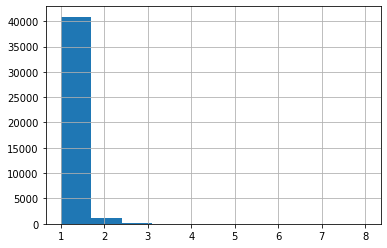

In [55]:
# Наглядно представим распределение пользоветелей по частоте совершаемых покупок
rfm.Frequency.hist()

Из графика ничего не понятно. Пойдем другим путем

In [56]:
rfm.groupby('Frequency').agg({'CustomerID': 'count'})

,CustomerID
Frequency,
1,40883
2,1075
3,74
4,13
5,4
6,1
8,1


Стало лучше. Для деления на ранги возьмем такие границы: <br>
1 - 1 заказ (единичные покупки) <br>
2 - 2 заказа (покупают нечасто) <br>
3 - 3 и более (покупают часто) <br>


In [57]:
# Теперь возьмем квантили 0.33 и 0.66 для деления кластеров на три примерно равных диапозона
quintiles = rfm[['Recency', 'Monetary']].quantile([.33, .66]).to_dict()

Т.о. каждый из рангов имеет следующие границы: <br>
<br>
Recency <br>
1 - более 176 дней (давние клиенты)<br>
2 - от 72 до 175 дней (относительно недавние клиенты)<br>
3 - до 71 дня (недавние клиенты)<br>
<br>
Frequency <br> 
1 - 1 заказ (единичные покупки)<br>
2 - 2 заказа (покупают нечасто)<br>
3 - 3 и более (покупают часто)<br>
<br>
Monetary<br>
1 - до 58.1 у.е.(маленькая сумма)<br>
2 - от 58.1 (невключительно) до 120.0 у.е. (средняя сумма)<br>
3 - более 120.0 у.е.(большая сумма)<br>

In [58]:
# Создадим функции для присвоения рангов в каждом кластере

def r_score(x):
    if x <= quintiles['Recency'][.33]:
        return 3
    elif x <= quintiles['Recency'][.66]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles['Monetary'][.33]:
        return 1
    elif x <= quintiles['Monetary'][.66]:
        return 2
    else:
        return 3  
    
def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    else:
        return 3  

In [59]:
# Создадим новые столбцы с присвоением рангов

rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x))

In [60]:
# Выведим RFM_Score
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

Обозначим примерные группы на основании рангов в RFM модели

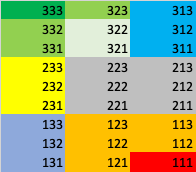

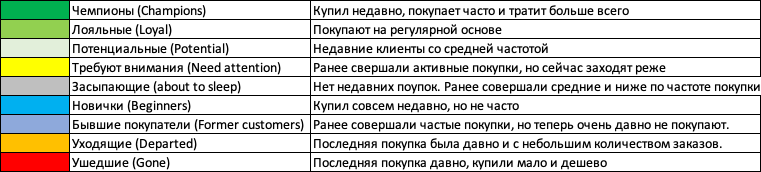

In [61]:
# Составим словарь, благодаря которому, 

segt_map = {
    r'2[1-2][1-3]': 'About to sleep',
    r'13[1-3]': 'Former customers',
    r'1[1-2][2-3]': 'Departed',
    r'23[1-3]': 'Need attention',
    r'32[1-3]': 'Potential',
    r'31[1-3]': 'Beginners',
    r'33[1-2]': 'Loyal',
    r'333': 'Champions',
    r'111': 'Gone',
    r'121': 'Departed'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)

In [62]:
# Интересно, что по итогу в рассматриваемом году нет клиентов группы Loyal
rfm['Segment'].unique()

array(['Departed', 'About to sleep', 'Beginners', 'Gone', 'Potential',
       'Former customers', 'Need attention', 'Champions'], dtype=object)

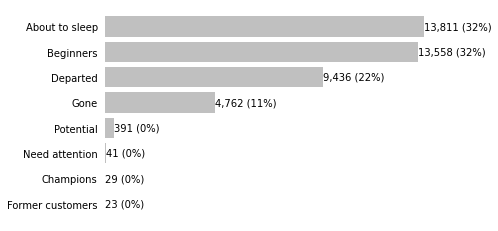

In [63]:
# Число пользователей в каждой из групп
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

В итоге мы видим, что за рассматриваемый период у нас преобладают клиенты из групп About to sleep, Beginners, Departed. <br>
Для того, чтобы это исправить, потребуется "реанимировать" старых клиентов, чтобы они вновь вернулись за покупками, а также удержать новеньких клиентов, чтобы перевести их в разряд лояльных